[View in Colaboratory](https://colab.research.google.com/github/Elenaires/Google-Machine-Learning-Crash-Course/blob/master/TensorFlow/first_steps_with_tensor_flow_notes.ipynb)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417
Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


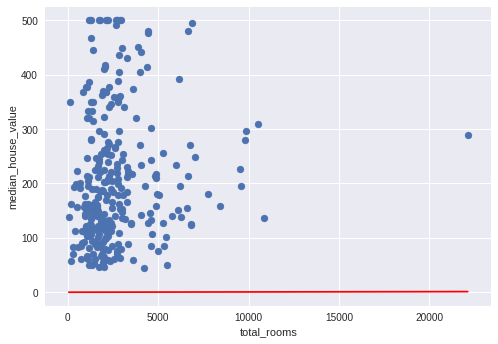

Training model...
RMSE (on training data):
   period 00 : 225.63
   period 01 : 214.42
   period 02 : 204.44
   period 03 : 194.97
   period 04 : 186.92
   period 05 : 180.53
   period 06 : 175.44
   period 07 : 172.26
   period 08 : 169.60
   period 09 : 167.70
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,114.2,207.3
std,94.2,116.0
min,0.1,15.0
25%,63.2,119.4
50%,91.9,180.4
75%,136.1,265.0
max,1638.9,500.0


Final RMSE (on training data): 167.70
Training model...
RMSE (on training data):
   period 00 : 225.63
   period 01 : 214.62
   period 02 : 205.05
   period 03 : 196.42
   period 04 : 189.80
   period 05 : 184.24
   period 06 : 180.42
   period 07 : 178.18
   period 08 : 176.77
   period 09 : 176.04
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,119.2,207.3
std,95.7,116.0
min,0.3,15.0
25%,65.9,119.4
50%,97.3,180.4
75%,143.5,265.0
max,2976.0,500.0


Final RMSE (on training data): 176.04


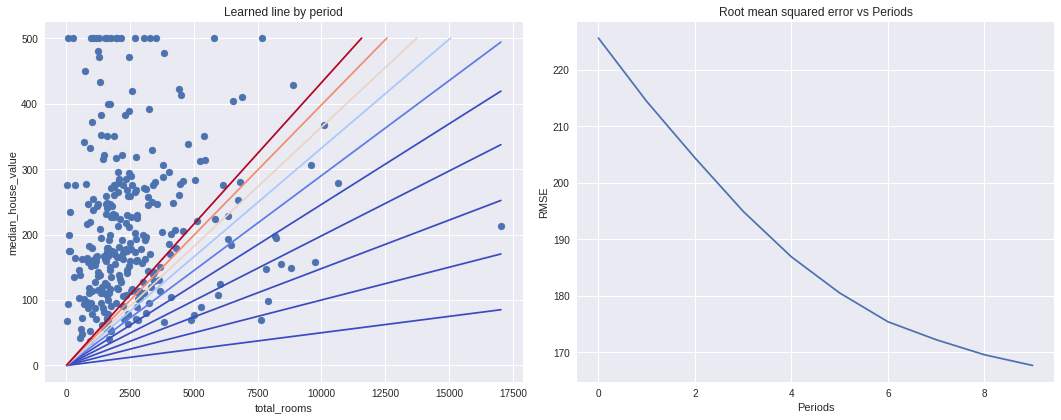

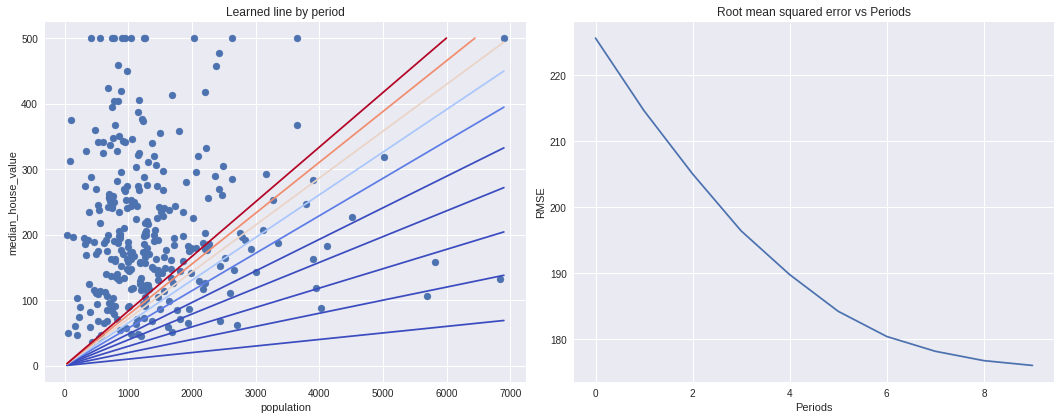

In [2]:
# load libraries
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# load dataset
california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

# randomized data
california_housing_dataframe = california_housing_dataframe.reindex(
np.random.permutation(california_housing_dataframe.index))

# scale median_house_value to be in units of thousands
california_housing_dataframe["median_house_value"] /= 1000.0

# examine data
california_housing_dataframe.describe()

# build the first model - predicting median house value using total rooms as feature
# STEP 1 : SPECIFY TYPE OF DATA FOR EACH FEATURE - CATEGORICAL OR NUMERICAL
#          VIA FEATURE COLUMN

# define the input feature
my_feature = california_housing_dataframe[["total_rooms"]]

# configure a numeric feature column
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

# STEP 2 : DEFINE THE TARGET
# define the label
targets = california_housing_dataframe["median_house_value"]

# STEP 3 : CONFIGURE THE LINEARREGRESSOR
# use gradient descent as the optimizer for training the model
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0000001)

# apply gradient clipping to our optimizer to ensures the magnitude of the
# gradient do not become too large during training
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# configure the linear regression model with feature(s) and optimizer
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns,
                                               optimizer=my_optimizer)

# STEP 4 : DEFINE INPUT FUNCTION
# to import housing data into the linearregressor
# instructs TF how to preprocess data, batch. shuffle and repeat during training

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  #Trains a linear regression model of one feature.
  
  # convert pandas data into a dict of NumPy arrays
  features = {key:np.array(value) for key,value in dict(features).items()}
  
  # construct a dataset object
  ds = Dataset.from_tensor_slices((features,targets))
  
  # break data into batches of batch_size, to be repeaated for the specified number
  # of epochs
  # when num_epochs=None is passed to repeat(), input data will be repeated indefinitely
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  # shuffle the data
  # buffer_size == size of dataset 
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
    
  # constructs an iterator for the detaset  
  # return the next batch of data to the LinearRegressor
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels
  
# STEP 5 : TRAIN THE MODEL for 100 steps
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100)

# STEP 6 : EVALUATE THE MODEL

# create an input function for predictions
# no shuffling/repeating required as we are making prediction for each example
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# make prediction
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# format prediction as NumPy array to calc error metrics
predictions = np.array([item['predictions'][0] for item in predictions])

# MSE
mean_squared_error = metrics.mean_squared_error(predictions, targets)

# RMSE
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

# compre RMSE to difference of min and max of targets
min_house_value = california_housing_dataframe["median_house_value"].min()

max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

# to see how well our predictions match our target - overall summary statistics
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["target"] = pd.Series(targets)
calibration_data.describe()

# make a readable scatter plot
sample = california_housing_dataframe.sample(n=300)

# plot the line
# Get the min and max total_rooms values
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generted during training
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# plot our regression line from (x_0,, y_0) to (x_1, y_1)
plt.plot([x_0, x_1], [y_0, y_1], c = 'r')

# Label the graph axes
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# plot a scatter plot from our data sample
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# display graph
plt.show()

# Tweak model hyperparameters in a single function
def train_model(learning_rate, steps, batch_size, input_feature = "total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A 'float', the learning rate.
    steps: A non-Zero 'int', the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
     batch_size: A nonzero 'int', the batch size.
     input_feature: A 'string' specifying a column from 'california_housing_dataframe'
      to use as input feature."""
  
  periods = 10
  steps_per_period = steps / periods
  
  #tf.enable_eager_execution?? 
  
  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]
  
  # create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # create a libear regressor object
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib. estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
                      feature_columns=feature_columns,
                      optimizer=my_optimizer)

  # set up to plot the state of our model's line each period
  plt.figure(figsize=(15, 6))
  plt.subplot(1,2,1)
  plt.title("Learned line by period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
      input_fn = training_input_fn,
      steps=steps_per_period
    )
    
    # Take a break and compute predictions
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("   period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list
    root_mean_squared_errors.append(root_mean_squared_error)
    #Finally, track the weights and biases over time
    # apply some math to ensure that the data and line are plotted neatly
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extends = (y_extents - bias) / weight
    x_extends = np.maximum(np.minimum(x_extends,
                                     sample[my_feature].max()),
                                      sample[my_feature].min())
    y_extends = weight * x_extends + bias
    plt.plot(x_extends, y_extends, color=colors[period])
  print("Model training finished")
  
  # output a graph of loss metrics over periods
  plt.subplot(1,2,2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root mean squared error vs Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)
  
  # output a table with calibration data
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())
  
  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  
# tweak model hyperparameters to achieve better RMSE
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
  )
     
# replaceing total_rooms feature with population
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
  )
    
    
  
  
  